In [2]:
#Import the libraries
import pandas as pd
from tqdm import tqdm
import numpy as np
from ipywidgets import interactive
import time
from numpy import *
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
# %matplotlib notebook
from scipy.optimize import minimize

In [3]:
#Plt rc congif for latex
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,latexsym}')

In [17]:
#Import the raw data
raw_data = np.loadtxt('nbse2.dat')
x = raw_data.T[2]
y = raw_data.T[3]
k = raw_data.T[4]

(-4.284365, 2.6593850000000003, -7.5175, 6.6379600000000005)

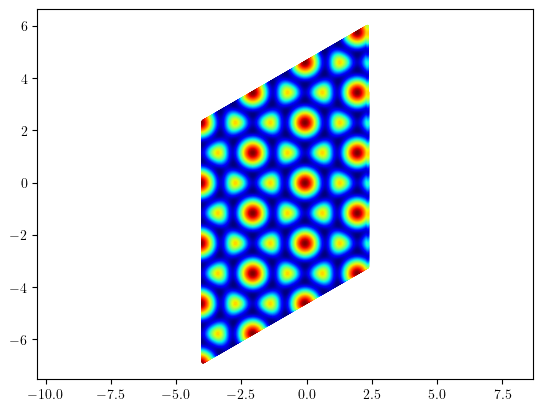

In [21]:
plt.scatter(x,y,c=k,cmap='jet',s=1)
plt.axis("equal")
plt.show()

In [22]:
#The data in pandas
data = pd.DataFrame()
data['x'] = x
data['y'] = y
data['k'] = k

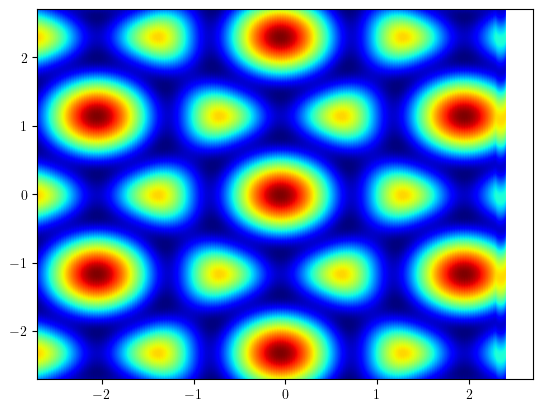

In [23]:
plt.scatter(x,y,c=k,cmap="jet")
plt.xlim(-2.7,2.7)
plt.ylim(-2.7,2.7)
plt.show()

In [24]:
big = pd.read_csv('nbse2.dat', sep='\s+', header=None,names=[0, 1, 'x', 'y', 'k']).drop([0, 1], axis=1)
zone = big.query(" -2.7  <= x  <= 2.7 ").query(" -2.7  <= y  <= 2.7 ")
reduced_zone = big.query(" -1.8  <= x  <= 1.8 ").query(" -1.8  <= y  <= 1.8 ")

fs=zone.query(" -0.02  <= k  <= 0.02 ")
fs_x=fs.x.values
fs_y=fs.y.values

fs_x_r=reduced_zone.query(" -0.02  <= k  <= 0.02 ")
fs_y_r=reduced_zone.query(" -0.02  <= k  <= 0.02 ")

(-2.947253, 2.595713, -2.9670305, 2.9670405)

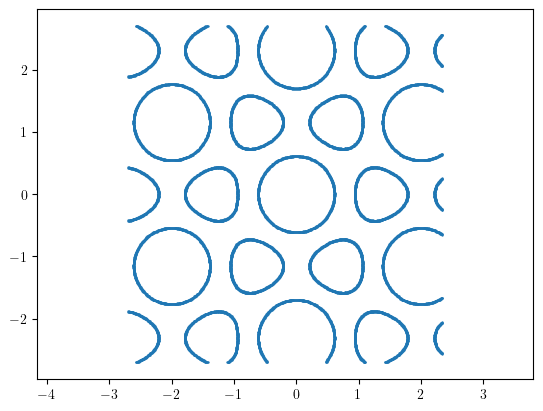

In [37]:
plt.scatter(fs_x,fs_y,s=0.5)
plt.axis("equal")

In [25]:
q1=array([0,1.15*2/3])
q2=array([1.15*sqrt(3)/2*2/3,-1/2*2/3*1.15])
q3=array([-1.15*sqrt(3)/2*2/3,-1/2*2/3*1.15])

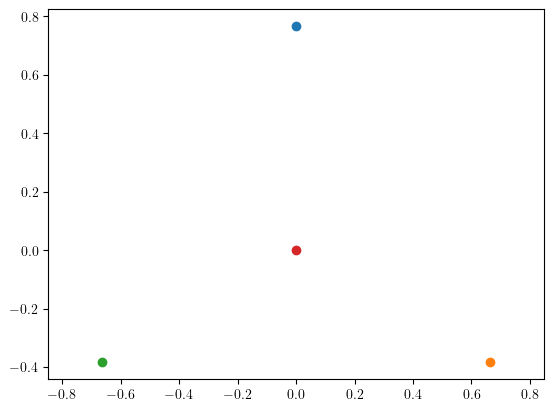

In [30]:
plt.scatter(q1[0],q1[1])
plt.scatter(q2[0],q2[1])
plt.scatter(q3[0],q3[1])
plt.scatter(0,0)
plt.axis("equal")
plt.show()

In [38]:
q_vec=[q1,q2,q3,-q1,-q2,-q3]

In [39]:
q_nesting=np.zeros((1,2))
error=0.01
for q in q_vec:
    for begin in tqdm(range(len(fs_x))):
        for end in range(len(fs_x)):
            if q[0]-error<fs_x[begin]-fs_x[end]<q[0]+error:
                if q[1]-error<fs_y[begin]-fs_y[end]<q[1]+error:
                    q_nesting=np.append(q_nesting,[[fs_x[begin],fs_y[begin]]],axis=0)

100%|██████████| 10905/10905 [00:28<00:00, 377.55it/s]


In [40]:
q_data=pd.DataFrame()
q_data['x']=q_nesting[:,0]
q_data['y']=q_nesting[:,1]
q_data=q_data.query('-1.8 <= x <= 1.8').query('-1.8 <= y <= 1.8')

In [41]:
q_data.describe()

,x,y
count,8037.000000,8037.000000
mean,-0.020284,0.000006
std,1.036390,1.044392
min,-1.789050,-1.799700
25%,-0.937490,-0.852490
50%,-0.093740,0.000010
75%,0.937510,0.852500
max,1.789070,1.799710


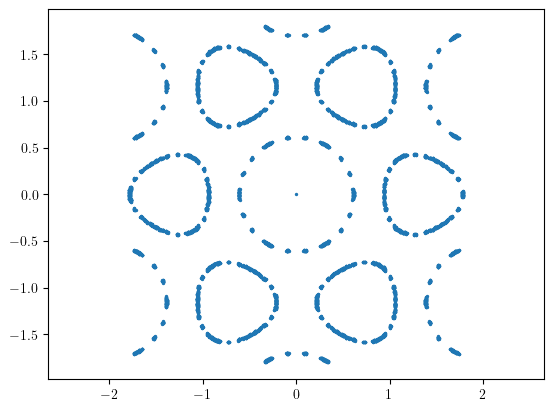

In [45]:
plt.scatter(q_data.x.values,q_data.y.values,s=2)
plt.axis('equal')
plt.show()

In [46]:
def gaussian(x,y,cx=0,cy=0,sigma=0.03):
    func = exp(-((x-cx)**2+(y-cy)**2)/sigma**2)
    return func

In [47]:
cx=q_data.x.values
cy=q_data.y.values

In [48]:
def test_function(data,c):
    cx=c.x.values
    cy=c.y.values
    x=data.x.values
    y=data.y.values
    
    g_func = array([sum(gaussian(x[i],y[i],cx,cy)) for i  in range(len(data))]) 
    return(g_func)
    
    
    

In [49]:
g_func=test_function(reduced_zone,q_data)

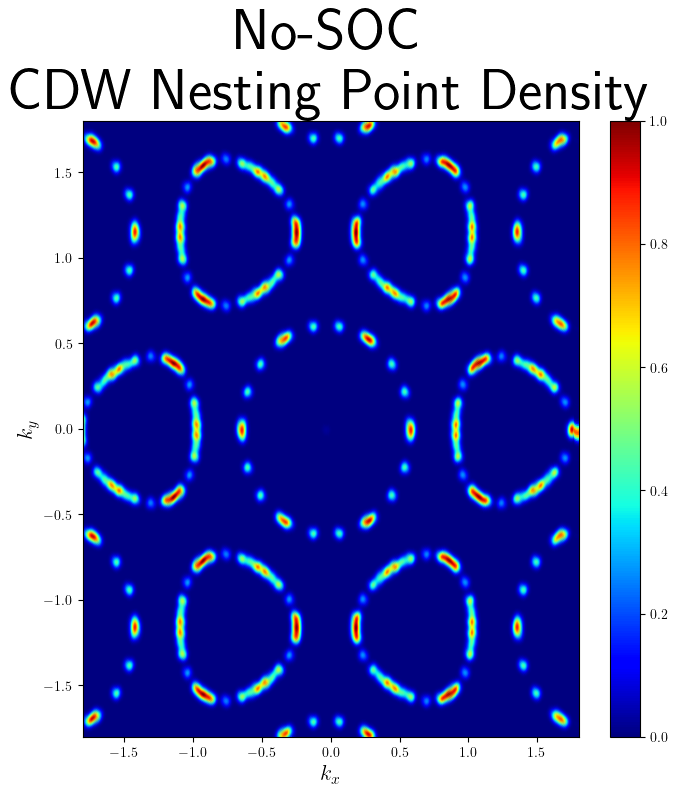

In [50]:
fig=plt.figure(figsize=(8,8))
plt.scatter(reduced_zone.x,reduced_zone.y,c=g_func/g_func.max(),cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.xlim(-1.8,1.8)
plt.ylim(-1.8,1.8)
plt.xlabel(r'$k_x$',fontsize=16)
plt.ylabel(r'$k_y$',fontsize=16)
plt.title('No-SOC \n CDW Nesting Point Density',fontsize=42)
# plt.savefig("../Plot/real_density_no.jpg", format='jpg', transparent=False)
plt.show()

In [23]:
class CDW:
    def __init__(self,bz,nesting=q_data):
        self.kx=bz.x.values
        self.ky=bz.y.values
#         self.kx=bz.query('-0.02 <= k <= 0.02').x.values
#         self.ky=bz.query('-0.02 <= k <= 0.02').y.values
#         self.k=bz.k.values
        self.q_nesting=nesting
        self.fX=bz.query('-0.02 <= k <= 0.02').x.values
        self.fY=bz.query('-0.02 <= k <= 0.02').y.values

    def box(self,parameters):
#         Box00re,Box00im,Box11re,Box11im,Box_1_1re,Box_1_1im,Box1_1re,Box1_1im,Box_11re,Box_11im,Box20re,Box20im,Box_20re,Box_20im,Box_12re,Box_12im,Box1_2re,Box1_2im,Box2_1re,Box2_1im,Box_21re,Box_21im=parameters
        Box11re,Box_1_1re,Box1_1re,Box_11re,Box20re,Box_20re,Box_12re,Box1_2re=parameters
        beta=9.42
        a1=sqrt(3)/2
        a2=1/2
        a3=3/2
        a4=sqrt(3)
#         zero=Box00re+1j*Box00im
        oneone = (Box11re)*(exp(beta*1j*(a1*self.ky-a2*self.kx))+exp(beta*1j*(-a1*self.ky-a2*self.kx))+exp(beta*1j*self.kx))
        _one_one = (Box_1_1re)*(exp(-beta*1j*(a1*self.ky-a2*self.kx))+exp(-beta*1j*(-a1*self.ky-a2*self.kx))+exp(-beta*1j*self.kx))
        _oneone=(Box_11re)*(exp(beta*1j*(a3*self.kx-a1*self.ky))+exp(beta*1j*(-a3*self.kx-a1*self.ky))+exp(beta*1j*a4*self.ky))
        one_one=(Box1_1re)*(exp(-beta*1j*(a3*self.kx-a1*self.ky))+exp(-beta*1j*(-a3*self.kx-a1*self.ky))+exp(-beta*1j*a4*self.ky))
        twozero=(Box20re)*(exp(beta*1j*(-self.kx-sqrt(3)*self.ky))+exp(beta*1j*2*self.kx)+exp(beta*1j*(-self.kx+sqrt(3)*self.ky)))
        _twozero=(Box_20re)*(exp(-beta*1j*(-self.kx-sqrt(3)*self.ky))+exp(-beta*1j*2*self.kx)+exp(-beta*1j*(-self.kx+sqrt(3)*self.ky)))
        _onetwo=(Box_12re)*(exp(beta*1j*(-self.kx/2+3*sqrt(3)/2*self.ky))+exp(beta*1j*(5/2*self.kx-sqrt(3)/2*self.ky))+exp(-beta*1j*(2*self.kx+sqrt(3)*self.ky)))
        one_two=(Box1_2re)*(exp(-beta*1j*(-self.kx/2+3*sqrt(3)/2*self.ky))+exp(-beta*1j*(5/2*self.kx-sqrt(3)/2*self.ky))+exp(beta*1j*(2*self.kx+sqrt(3)*self.ky)))
#         two_one=(Box2_1re)*(exp(-beta*1j*(self.kx/2+3*sqrt(3)/2*self.ky))+exp(beta*1j*(5/2*self.kx+sqrt(3)/2*self.ky))+exp(beta*1j*(-2*self.kx+sqrt(3)*self.ky)))
#         _twoone=(Box_21re)*(exp(beta*1j*(self.kx/2+3*sqrt(3)/2*self.ky))+exp(-beta*1j*(5/2*self.kx+sqrt(3)/2*self.ky))+exp(-beta*1j*(-2*self.kx+sqrt(3)*self.ky)))
#         gap=abs(zero+oneone+_one_one+_oneone+one_one+twozero+_twozero+_onetwo+one_two+two_one+_twoone)+two_one+_twoone)
        gap=abs(oneone+_one_one+_oneone+one_one+twozero+_twozero+_onetwo+one_two)

        
        gap=abs(oneone+_one_one+_oneone+one_one+twozero+_twozero+_onetwo+one_two)

        
        return gap
    
    def plot(self,parameters,name,soc):
        Box11re,Box_1_1re,Box1_1re,Box_11re,Box20re,Box_20re,Box_12re,Box1_2re=parameters
#         Box11re,Box11im,Box_1_1re,Box_1_1im,Box1_1re,Box1_1im,Box_11re,Box_11im,Box20re,Box20im,Box_20re,Box_20im,Box_12re,Box_12im,Box1_2re,Box1_2im=parameters
        fig=plt.figure(figsize=(18,18))
        gap=self.box(parameters)
        plt.scatter(self.kx,self.ky,c=gap/gap.max(),cmap=plt.get_cmap("jet"))
        plt.colorbar()
#         plt.scatter(bz.x,bz.y,alpha=0.01,c="white")
        plt.scatter(self.fX,self.fY,s=3,c="black")
#         plt.scatter(self.q_nesting.x,self.q_nesting.y,c="white",s=5)
        plt.xlim(-1.8,1.8)
        plt.ylim(-1.8,1.8)
#         plt.axis("equal")
        plt.title(r'{}'.format(soc)+'\n' 
                  r'CDW Order Parameter' '\n'
                  +r' Fundamental Mode $\quad$'
                  +r'$\Box_{1,1}$' + r'= {}'.format(Box11re)+ r' $\quad$'
                  +r'$\Box_{-1,-1}$ ='+ r' {}'.format(Box_1_1re)
                  +"\n"
                  +r' First Extension $\quad$'
                  +r'$\Box_{1,-1}$' + r'= {}'.format(Box1_1re)+ r' $\quad$'
                  +r'$\Box_{-1,1}$ ='+ r' {}'.format(Box_11re)       
                  +"\n"
                  +r'2M Mode $\quad$'
                  +r'$\Box_{2,0}$' + r'= {}'.format(Box20re)+ r' $\quad$'
                  +r'$\Box_{-2,0}$ ='+ r' {}'.format(Box_20re) 
                  +"\n"
                  +r'Second Extension $\quad$'
                  +r'$\Box_{-1,2}$' + r'= {}'.format(Box_12re)+ r' $\quad$'
                  +r'$\Box_{1,-2}$ ='+ r' {}'.format(Box1_2re) 
                  +"\n"
                  +"\n   .",fontsize=16)
        plt.savefig("../Plot/{}.jpg".format(name), format='jpg', transparent=False)     
#         plt.close()
#         plt.title(r"No-SOC Theoretical CDW vs Numerical Prediction" "\n" r'$\displaystyle\Box0,0}'r'$' "={} " "\n" r'$\displaystyle\Box_{1,1}'r'$'"\n" r'$\displaystyle\Box_{-1,-1}'r'$'.format(0), fontsize=16)

        plt.show()

In [24]:
model = CDW(reduced_zone)

In [25]:
def cost_function(parameter):
    cost = (model.box(parameter)-g_func)**2
    return cost.sum()

In [26]:
cost_function(random.rand(8))

5626048.225744682

In [ ]:
res8 = minimize(cost_function, np.random.randn(8).tolist(), method='Nelder-Mead', tol=1e-4)

In [ ]:
costs = [cost_function(cost) for cost in  [res2,res4,res6,res8,res10]]

In [ ]:
model.plot(np.round(res2.x,3),'real_fundamental_no',"No-SOC")